# User manual:
Our project was implemented wholly in the form of Jupyter notebook, and all the necessary files were correctly named and included in the same folder as the notebook to ease the re-implementation process. The notebook was already optimized in order to avoid the problem of "hidden state" due to non-sequential execution of cells. 

To use our work, the jury only need to select the option “Run all” inside the notebook to replicate our results. The results in the sentiment analysis task might slightly vary due to the randomness of the training process, but the results in the classification task should be approximately the same as the ones we reported in the report. Further support will be provided where necessary in the notebook, in the form of comments and markdown cells.

# 1. Installing/importing necessary libraries and importing data.

In [ ]:
# Installing the necessary libraries
!pip install numpy
!pip install pandas
!pip install gzip
!pip install nltk
!pip install matplotlib
!pip install torch
!pip install sklearn

In [2]:
# Importing the libraries:
import numpy as np
from copy import deepcopy
import re
import math
import sys
import gzip
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define a read vectors function to read the vectors from the file.
# This function can also be used on other files with the same format.
def read_vectors_file(filename):
    word_vectors = {}
    if filename.endswith('.gz'): fileObject = gzip.open(filename, 'rt', encoding='utf-8' )
    else: fileObject = open(filename, 'r', encoding='utf-8')    
    
    for line in fileObject:
        line = line.strip()
        if line:
            parts = line.split()
            word = parts[0]
            vector = [float(x) for x in parts[1:]]
            word_vectors[word] = np.array(vector) # Convert to numpy array for later use in the code
    return word_vectors

# Read the vectors from the file as a dictionary. 
vectors = read_vectors_file('vectors_datatxt_250_sg_w10_i5_c500_gensim_clean.gz')
fr_vectors = read_vectors_file('vecs100-linear-frwiki')

We can take a look at the imported data using the commands below.

In [4]:
print(f"The English vocabulary size is {len(vectors)}")
print(f"The French vocabulary size is {len(fr_vectors)}")
print(f"The English vector size is {len(vectors['dog'])}")
print(f"The French vector size is {len(fr_vectors['le'])}")

The English vocabulary size is 125777
The French vocabulary size is 150362
The English vector size is 250
The French vector size is 100


We created a small toy corpus for testing purpose. The corpus contains 10 simple words, which will be used to test the lexicons later.

In [5]:
# Toy corpus of 10 words:
toy_corpus = ['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect']

# Vectorize the toy corpus:
vec_toy_corpus = [vectors[word] for word in toy_corpus]


In [6]:
# We can also use gensim pre-trained models for the embedding. It's just too large or my laptop to run so we chose not to use it.
# Load the word2vec model:
#wv = api.load('word2vec-google-news-300')
#wv = w2v.Word2Vec(vector_size=250, min_count=500, window=8, sample=1e-3, workers=8, sg=1, hs=0, negative=10, epochs=5)

# Vectorize the toy corpus:
#vec_toy_corpus = [wv.wv[word] for word in toy_corpus]
#vec_toy_corpus = [wv[word] for word in toy_corpus]


We used the toy corpus to look at the original similarity between vectorized words using the original embedding. The pair of words can be changed if necessary.

In [7]:
# Compare vectors using cosine similarity:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute the cosine similarity matrix:
similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        similarity_matrix[i][j] = cosine_similarity(vec_toy_corpus[i], vec_toy_corpus[j])
print(f"The similarity between cat and feline is: {similarity_matrix[3][6]:.4f}")
# Print the cosine similarity matrix:
#for i in range(len(vec_toy_corpus)):
#    for j in range(len(vec_toy_corpus)):
#        print(f'Similarity between {toy_corpus[i]} and {toy_corpus[j]} is {similarity_matrix[i][j]:.4f}')

The similarity between cat and feline is: 0.5670


# 2. Implementing the original algorithm and finding the suitable lexicons for English and French datasets.

In [8]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  word = word.replace('[', '').replace(']', '').replace("'", '').replace('"', '').replace(':', '').replace(',', '').replace('.', '')
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename, encoding='utf-8'):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r', encoding=encoding)
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters, alpha = 1, beta = 1): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha
      newVec = alpha * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += beta * newWordVecs[ppWord] 
      newWordVecs[word] = newVec/(alpha + beta*numNeighbours) 
      # define a stopping mechanism using Euclidean distance
      # if distance too small, use the original vector
      if np.linalg.norm(newWordVecs[word] - wordVecs[word]) < 0.01:
        newWordVecs[word] = wordVecs[word]
  return newWordVecs

In [9]:
# Transform the toy corpus into a wordVecs dictionary:
toy_wordVecs = {}
for i in range(len(vec_toy_corpus)):
    toy_wordVecs[toy_corpus[i]] = vec_toy_corpus[i]
print(toy_wordVecs.keys())

dict_keys(['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect'])


In [10]:
# Create a French lexicon dictionary and add all synonyms, hypernyms, hyponyms
# It took a lot of time so I saved the dictionary in a file named "word_relations_lemma.txt". For some reasons, my laptop can't read the 'fra' lexicon in NLTK WordNet.

"""
import xml.etree.ElementTree as ET

# specify the path to the WOLF file
wolf_path = 'wolf-1.0b4.xml'

# parse the WOLF file
tree = ET.parse(wolf_path)
root = tree.getroot()

word_relations = {}

synsets = root.findall('SYNSET')
for synset in synsets:
    synset_id = synset.find('ID').text
    synonym_element = synset.find('SYNONYM')
    for literal in synonym_element.findall('LITERAL'):
        word = literal.text
        if word != '_EMPTY_':
            if word not in word_relations:
                word_relations[word] = []
            for ilr in synset.findall('ILR'):
                if ilr.get('type') in ['hypernym', 'hyponym']:
                    target_id = ilr.text
                    target_synset = root.find(f"SYNSET[ID='{target_id}']")
                    target_synonym_element = target_synset.find('SYNONYM')
                    for target_literal in target_synonym_element.findall('LITERAL'):
                        word_relations[word].append(target_literal.text) if target_literal.text != '_EMPTY_' else None

    
def export_dict_to_file(dictionary, filename):
    with open(filename, 'w', encoding = 'utf-8') as f:
        for key, value in dictionary.items():
            f.write(f"{key}: {value}\n")

export_dict_to_file(word_relations, 'word_relations_lemma.txt')"""



'\nimport xml.etree.ElementTree as ET\n\n# specify the path to the WOLF file\nwolf_path = \'wolf-1.0b4.xml\'\n\n# parse the WOLF file\ntree = ET.parse(wolf_path)\nroot = tree.getroot()\n\nword_relations = {}\n\nsynsets = root.findall(\'SYNSET\')\nfor synset in synsets:\n    synset_id = synset.find(\'ID\').text\n    synonym_element = synset.find(\'SYNONYM\')\n    for literal in synonym_element.findall(\'LITERAL\'):\n        word = literal.text\n        if word != \'_EMPTY_\':\n            if word not in word_relations:\n                word_relations[word] = []\n            for ilr in synset.findall(\'ILR\'):\n                if ilr.get(\'type\') in [\'hypernym\', \'hyponym\']:\n                    target_id = ilr.text\n                    target_synset = root.find(f"SYNSET[ID=\'{target_id}\']")\n                    target_synonym_element = target_synset.find(\'SYNONYM\')\n                    for target_literal in target_synonym_element.findall(\'LITERAL\'):\n                        wor

In [11]:
# Read the English lexicons from files:
frame_lexicon = read_lexicon('framenet.txt')
wn_lexicon = read_lexicon('wordnet-synonyms+.txt')
ppdb_lexicon = read_lexicon('ppdb-xl.txt')

# Read the French lexicon from file:
fr_lexicon = read_lexicon('word_relations_lemma.txt')

In [12]:
# Test the lexicons:
print(frame_lexicon['dog'])
print(wn_lexicon['dog'])
print(ppdb_lexicon['dog'])

# Test the French lexicon:
print(fr_lexicon['chien'])

['shepherd', 'accompany', 'pursuer', 'lead', 'show', 'track', 'stalk', 'guided', 'walk', 'trail', 'tail', 'usher', 'pursuit', 'escort', 'conduct', 'follow', 'shadow', 'hound', 'guide', 'pursue', 'chase']
['chase', 'chase_after', 'trail', 'tail', 'tag', 'give_chase', 'go_after', 'track', 'domestic_dog', 'canis_familiaris', 'andiron', 'firedog', 'dog-iron', 'pawl', 'detent', 'click', 'frank', 'frankfurter', 'hotdog', 'hot_dog', 'wiener', 'wienerwurst', 'weenie', 'cad', 'bounder', 'blackguard', 'hound', 'heel', 'frump', 'pursue', 'follow', 'domestic_animal', 'domesticated_animal', 'canine', 'canid', 'support', 'catch', 'stop', 'sausage', 'villain', 'scoundrel', 'chap', 'fellow', 'feller', 'fella', 'lad', 'gent', 'blighter', 'cuss', 'bloke', 'unpleasant_woman', 'disagreeable_woman', 'tree', 'run_down', 'quest', 'hound', 'hunt', 'trace', 'puppy', 'great_pyrenees', 'basenji', 'newfoundland', 'newfoundland_dog', 'lapdog', 'poodle', 'poodle_dog', 'leonberg', 'toy_dog', 'toy', 'spitz', 'pooch',

In [13]:
# Retrofit the word vectors using basic hyperparameters:
frame_newWordVecs = retrofit(toy_wordVecs, frame_lexicon, numIters = 10, alpha = 1, beta = 2)
wn_newWordVecs = retrofit(toy_wordVecs, wn_lexicon, numIters = 10, alpha = 1, beta = 2)
ppdb_newWordVecs = retrofit(toy_wordVecs, ppdb_lexicon, numIters = 10, alpha = 1, beta = 2)

# Similarity matrix after retrofitting:
frame_retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
wn_retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
ppdb_retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))

for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        frame_retro_similarity_matrix[i][j] = cosine_similarity(frame_newWordVecs[toy_corpus[i]], frame_newWordVecs[toy_corpus[j]])

for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        wn_retro_similarity_matrix[i][j] = cosine_similarity(wn_newWordVecs[toy_corpus[i]], wn_newWordVecs[toy_corpus[j]])
        
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        ppdb_retro_similarity_matrix[i][j] = cosine_similarity(ppdb_newWordVecs[toy_corpus[i]], ppdb_newWordVecs[toy_corpus[j]])        
# Print the cosine similarity matrix:
frame_retrofit_effect_matrix = frame_retro_similarity_matrix - similarity_matrix
wn_retrofit_effect_matrix = wn_retro_similarity_matrix - similarity_matrix
ppdb_retrofit_effect_matrix = ppdb_retro_similarity_matrix - similarity_matrix

print(f"The frame similarity between cat and feline is: {frame_retro_similarity_matrix[3][6]:.4f}")
print(f"The wn similarity between cat and feline is: {wn_retro_similarity_matrix[3][6]:.4f}")
print(f"The ppdb similarity between cat and feline is: {ppdb_retro_similarity_matrix[3][6]:.4f}")

print(f'Similarity is changed by {frame_retrofit_effect_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {wn_retrofit_effect_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {ppdb_retrofit_effect_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')

print('There has been some improvements in the toy corpus, so the retrofit algorithm works! We can move on to find the better hyperparameters.')
print("It seems that wn_lexicon is the better lexicon, so we will use it for the rest of the assignment.")

The frame similarity between cat and feline is: 0.5670
The wn similarity between cat and feline is: 0.9337
The ppdb similarity between cat and feline is: 0.5670
Similarity is changed by 0.0000 between cat and feline
Similarity is changed by 0.3668 between cat and feline
Similarity is changed by 0.0000 between cat and feline
There has been some improvements in the toy corpus, so the retrofit algorithm works! We can move on to find the better hyperparameters.
It seems that wn_lexicon is the better lexicon, so we will use it for the rest of the assignment.


# 3. Implement the algorithm in matrix form.

In order to implement the retrofitting algorithm in the matrix form, we assumed that the input is the original word embeddings matrix E(w), and the output is the retrofitted word embeddings matrix E'(w). The retrofitting algorithm will be applied to E(w) to get E'(w).

To do this, we will have to change the way the lexicon works. At the moment, it is a dictionary with words as keys and their neighbors as values, but to be used in matrix form, the words have to be encoded to access the word embeddings matrix E(w) and E'(w). We encoded the words using a word_ids dictionary and a word_indices list, using the following function:

In [14]:
# Word ids and indices:
def build_word_index_mappings(word_vectors):
    word_to_index = {}
    index_to_word = []
    for i, word in enumerate(word_vectors.keys()):
        word_to_index[word] = i
        index_to_word.append(word)
    return word_to_index, index_to_word

word_ids, word_indices = build_word_index_mappings(vectors)
fr_word_ids, fr_word_indices = build_word_index_mappings(fr_vectors)


In [15]:
# Take a look at the lexicon:
print(word_ids['dog'])
print(wn_lexicon['dog'])
print(len(wn_lexicon['dog']))
print(fr_word_ids['chien'])
print(fr_lexicon['chien'])

2122
['chase', 'chase_after', 'trail', 'tail', 'tag', 'give_chase', 'go_after', 'track', 'domestic_dog', 'canis_familiaris', 'andiron', 'firedog', 'dog-iron', 'pawl', 'detent', 'click', 'frank', 'frankfurter', 'hotdog', 'hot_dog', 'wiener', 'wienerwurst', 'weenie', 'cad', 'bounder', 'blackguard', 'hound', 'heel', 'frump', 'pursue', 'follow', 'domestic_animal', 'domesticated_animal', 'canine', 'canid', 'support', 'catch', 'stop', 'sausage', 'villain', 'scoundrel', 'chap', 'fellow', 'feller', 'fella', 'lad', 'gent', 'blighter', 'cuss', 'bloke', 'unpleasant_woman', 'disagreeable_woman', 'tree', 'run_down', 'quest', 'hound', 'hunt', 'trace', 'puppy', 'great_pyrenees', 'basenji', 'newfoundland', 'newfoundland_dog', 'lapdog', 'poodle', 'poodle_dog', 'leonberg', 'toy_dog', 'toy', 'spitz', 'pooch', 'doggie', 'doggy', 'barker', 'bow-wow', 'cur', 'mongrel', 'mutt', 'mexican_hairless', 'hunting_dog', 'working_dog', 'dalmatian', 'coach_dog', 'carriage_dog', 'pug', 'pug-dog', 'corgi', 'welsh_corgi'

In [16]:
# Create a new dictionary to store the lexicon with word IDs
# This dictionary will have as keys the word IDs and as values the list of IDs of the words in the lexicon that are related to the key. The words not present in the vocabulary are ignored.
# This is done to ensure that the IDs of the words in the lexicon are the same as the IDs of the words in the vocabulary.
wn_lexicon_with_ids = {}

# We iterate through the keys of the lexicon, and replace by the word IDs. Skip if not in the vocabulary.
for word in wn_lexicon.keys():
    if word not in word_ids:
        continue
    else:
        wn_lexicon_with_ids[word_ids[word]] = [word_ids[w] for w in wn_lexicon[word] if w in word_ids.keys()]
        
# Do the same for french lexicon:
fr_lexicon_with_ids = {}

for word in fr_lexicon.keys():
    if word not in fr_word_ids:
        continue
    else:
        fr_lexicon_with_ids[fr_word_ids[word]] = [fr_word_ids[w] for w in fr_lexicon[word] if w in fr_word_ids.keys()]


In [17]:
print(f"The number of neighbors for 'dog' is {len(wn_lexicon_with_ids[word_ids['dog']])} after removing words not in the vocabulary.")
print(f"The number of neighbors for 'chien' is {len(fr_lexicon_with_ids[fr_word_ids['chien']])} after removing words not in the vocabulary.")

The number of neighbors for 'dog' is 53 after removing words not in the vocabulary.
The number of neighbors for 'chien' is 3 after removing words not in the vocabulary.


In [18]:
# Create a new dictionary to store antonyms from WordNet:
antonyms = {}

# Get the antonyms from WordNet and store them in the dictionary
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        for antonym in lemma.antonyms():
            word = lemma.name()
            antonym_word = antonym.name()
            if word in word_ids and antonym_word in word_ids:
                antonyms[word_ids[word]] = word_ids[antonym_word]
print("We will not use the antonyms in this assignment, because it seems to lower the performance of the model in our implementation. But it is an option to improve the similarity for downstream task.")


We will not use the antonyms in this assignment, because it seems to lower the performance of the model in our implementation. But it is an option to improve the similarity for downstream task.


In [19]:
# Test new lexicons:
print(wn_lexicon_with_ids.get(word_ids['dog'])) # dog
print(word_indices[antonyms.get(word_ids['right'])])
print(word_indices[antonyms.get(word_ids['above'])])

[3976, 3004, 4885, 2323, 628, 119837, 4064, 1675, 36730, 114003, 20248, 105882, 24027, 19729, 14793, 4721, 1550, 22357, 265, 3559, 959, 18002, 9909, 69569, 25414, 1666, 46171, 42210, 17849, 29517, 105981, 25817, 1947, 6109, 19729, 3446, 7013, 17798, 7860, 43170, 6316, 38975, 52235, 67663, 60179, 9590, 34751, 72560, 36218, 38783, 50015, 60126, 47213]
wrong
below


In [20]:
# Create the embedding matrix:
embedding_matrix = np.zeros((len(word_indices), len(vectors['the'])))
fr_embedding_matrix = np.zeros((len(fr_word_indices), len(fr_vectors['le'])))

# Fill the embedding matrix with the word vectors from the word2vec model
for i in range(len(word_indices)):
    embedding_matrix[i] = vectors[word_indices[i]]   
    
for i in range(len(fr_word_indices)):
    fr_embedding_matrix[i] = fr_vectors[fr_word_indices[i]]

In [21]:
# Create a neighbor matrix from the new lexicon:
# The value for each word is the sum of the embeddings of the words in the lexicon that are related to the word
neighbor_matrix = np.zeros((len(word_indices), len(vectors['the']))) # It's a matrix of size (vocab_size, 250)
fr_neighbor_matrix = np.zeros((len(fr_word_indices), len(fr_vectors['le']))) # It's a matrix of size (vocab_size, 100)

# Fill the neighbor matrix:
# For each word in the lexicon, we sum the embeddings of the words in the lexicon that are related to the word
for key in wn_lexicon_with_ids.keys():
    neighbor_matrix[key] = np.sum(embedding_matrix[wn_lexicon_with_ids[key]], axis = 0)
    
for key in fr_lexicon_with_ids.keys():
    fr_neighbor_matrix[key] = np.sum(fr_embedding_matrix[fr_lexicon_with_ids[key]], axis = 0)

# Create an array of number of neighbors for each word:
num_neighbors = np.zeros(len(word_indices))
for key in wn_lexicon_with_ids.keys():
    num_neighbors[key] = len(wn_lexicon_with_ids[key])
num_neighbors[num_neighbors == 0] = 1e-6 # To avoid division by 0

fr_num_neighbors = np.zeros(len(fr_word_indices))
for key in fr_lexicon_with_ids.keys():
    fr_num_neighbors[key] = len(fr_lexicon_with_ids[key])
fr_num_neighbors[fr_num_neighbors == 0] = 1e-6 # To avoid division by 0

# Divide each row of the neighbor matrix by the number of neighbors for the corresponding word
neighbor_matrix = neighbor_matrix / num_neighbors[:, None]
fr_neighbor_matrix = fr_neighbor_matrix / fr_num_neighbors[:, None]

In [22]:
# Test the neighbor matrix:
print(wn_lexicon_with_ids[word_ids['dog']]) 
print(embedding_matrix[wn_lexicon_with_ids[word_ids['dog']]].shape) 
print(neighbor_matrix[word_ids['dog']].shape)
print(num_neighbors[word_ids['dog']]) 
print('\n')
print(fr_lexicon_with_ids[fr_word_ids['chien']]) 
print(fr_embedding_matrix[fr_lexicon_with_ids[fr_word_ids['chien']]].shape)
print(fr_neighbor_matrix[fr_word_ids['chien']].shape)
print(fr_num_neighbors[fr_word_ids['chien']])

[3976, 3004, 4885, 2323, 628, 119837, 4064, 1675, 36730, 114003, 20248, 105882, 24027, 19729, 14793, 4721, 1550, 22357, 265, 3559, 959, 18002, 9909, 69569, 25414, 1666, 46171, 42210, 17849, 29517, 105981, 25817, 1947, 6109, 19729, 3446, 7013, 17798, 7860, 43170, 6316, 38975, 52235, 67663, 60179, 9590, 34751, 72560, 36218, 38783, 50015, 60126, 47213]
(53, 250)
(250,)
53.0


[3, 15233, 40254]
(3, 100)
(100,)
3.0


In [23]:
# Create an antonym matrix:
antonym_matrix = np.zeros((len(word_indices), 250))

# Fill the antonym matrix:
#for key in antonyms.keys():
    #antonym_matrix[key] = embedding_matrix[antonyms[key]]

In [24]:
# Define the retrofitting algorithm, using the previously found hyperparameters:
def retrofit_matrix(embedding_matrix, neighbor_matrix, num_neighbors, alpha = 1, beta = 1, nb_iters = 10):
    new_embedding_matrix = embedding_matrix
    for i in np.arange(nb_iters):
        new_embedding_matrix = (alpha * new_embedding_matrix * num_neighbors[:, None] + beta * (neighbor_matrix)) / (alpha + beta * num_neighbors[:, None]) # If we want to use the antonym matrix, we can subtract from the neighbor matrix
        # Implement a stopping criterion: If the norm of the difference between the new and the old embedding matrix is less than 1e-2, stop the algorithm
        if np.linalg.norm(new_embedding_matrix - embedding_matrix) < 1e-2:
            break
    return new_embedding_matrix

# Run the algorithm on the embedding matrix using recommended hyperparameters:
retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix, num_neighbors, alpha = 1, beta = 1, nb_iters = 10)
fr_retrofitted_matrix = retrofit_matrix(fr_embedding_matrix, fr_neighbor_matrix, fr_num_neighbors, alpha = 1, beta = 1, nb_iters = 10)

In [25]:
# We can also improve the algorithm further by calculating a difference vector for all retrofitted vectors, and apply this difference vector on the words which were not present in the lexicon. This is done in the following code:
# Calculate the difference vector:
"""diff_vec = np.zeros(250)
for word in word_ids.keys():
    if word in wn_lexicon.keys():
        diff_vec += (retrofitted_matrix[word_ids[word]] - embedding_matrix[word_ids[word]])
diff_vec = diff_vec / len(word_ids.keys())

# Apply the difference vector on the words which were not present in the lexicon:
for word in word_ids.keys():
    if word not in wn_lexicon.keys():
        retrofitted_matrix[word_ids[word]] = embedding_matrix[word_ids[word]] + diff_vec"""

'diff_vec = np.zeros(250)\nfor word in word_ids.keys():\n    if word in wn_lexicon.keys():\n        diff_vec += (retrofitted_matrix[word_ids[word]] - embedding_matrix[word_ids[word]])\ndiff_vec = diff_vec / len(word_ids.keys())\n\n# Apply the difference vector on the words which were not present in the lexicon:\nfor word in word_ids.keys():\n    if word not in wn_lexicon.keys():\n        retrofitted_matrix[word_ids[word]] = embedding_matrix[word_ids[word]] + diff_vec'

# 4. Evaluations.
We will evaluate the new retrofitted word embeddings on a lexical similarity task, and a sentiment analysis task.
## 4.1. Lexical similarity task.
We will use the WS353 and RG65 dataset to evaluate the performance of the retrofitting algorithm on a lexical similarity task. The WS353 dataset contains 353 pairs of words, RG65 contains 65 pairs, and each pair is assigned a similarity score by human annotators. The similarity score ranges from 0 to 10, with 0 being not similar at all, and 10 being very similar. We will use the cosine similarity between the word embeddings of each pair of words to calculate the similarity score, and then compare it with the human similarity score to see how well the retrofitting algorithm performs.

In [26]:
# Read the WordSim353 and RG65 datasets as pandas dataframes:
# It is done with pandas for ease of manipulation, and also ease of calculation of the correlation between the human scores and the cosine similarities
# Because the formats of two datasets are different, I read them separately
def read_ws353():
    with open('ws353.txt', 'r') as f:
        data = f.read()
    lines = data.split('\n')
    lines = lines[0:-1]
    word1 = []
    word2 = []
    human_scores = []
    for line in lines:
        tokens = line.split('\t')
        word1.append(tokens[0])
        word2.append(tokens[1])
        human_scores.append(float(tokens[2]))
    df = pd.DataFrame({'word1': word1, 'word2': word2, 'score': human_scores})

    return df

ws353_data = read_ws353()

def read_rg65():
    with open('rg65_french.txt', 'r', encoding = 'utf-8') as f:
        data = f.read()
    lines = data.split('\n')
    lines = lines[0:-1]
    word1 = []
    word2 = []
    human_scores = []
    for line in lines:
        tokens = line.split(' ')
        word1.append(tokens[0])
        word2.append(tokens[1])
        human_scores.append(float(tokens[2]))
    df = pd.DataFrame({'word1': word1, 'word2': word2, 'score': human_scores})

    return df

rg65_data = read_rg65()
    

In [27]:
print("WS353 dataset:")
print(ws353_data)
print("RG65 dataset:")
print(rg65_data)

WS353 dataset:
            word1     word2  score
0            love       sex   6.77
1           tiger       cat   7.35
2           tiger     tiger  10.00
3            book     paper   7.46
4        computer  keyboard   7.62
..            ...       ...    ...
348        shower     flood   6.03
349       weather  forecast   8.34
350      disaster      area   6.25
351      governor    office   6.34
352  architecture   century   3.78

[353 rows x 3 columns]
RG65 dataset:
         word1      word2  score
0        corde    sourire   0.00
1         midi    ficelle   0.00
2          coq    périple   0.06
3        fruit  fournaise   0.11
4   autographe     rivage   0.00
..         ...        ...    ...
60     coussin   oreiller   3.00
61   cimetière  cimetière   4.00
62  automobile       auto   3.94
63       joyau      bijou   3.22
64        midi      dîner   2.17

[65 rows x 3 columns]


In [28]:
# Create a function to compute the cosine similarity between two words:
def emb_cosine_similarity(word1, word2, embedding_matrix, word_ids):
    if word1 not in word_ids or word2 not in word_ids:
        return None
    word1_embedding = embedding_matrix[word_ids[word1]]
    word2_embedding = embedding_matrix[word_ids[word2]]
    return np.dot(word1_embedding, word2_embedding) / (np.linalg.norm(word1_embedding) * np.linalg.norm(word2_embedding))

# Calculate the score for each pair of words in the dataset:
ws353_data['original_score'] = ws353_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], embedding_matrix, word_ids), axis = 1)
ws353_data['retrofitted_score'] = ws353_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], retrofitted_matrix, word_ids), axis = 1)

# Calculate the score for each pair of words in the French dataset:
rg65_data['original_score'] = rg65_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], fr_embedding_matrix, fr_word_ids), axis = 1)
rg65_data['retrofitted_score'] = rg65_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], fr_retrofitted_matrix, fr_word_ids), axis = 1)


In [29]:
# Because there are some words in the dataset that are not in the vocabulary, we need to remove them from the dataset before calculation of the correlation:
ws353_data = ws353_data.dropna()
rg65_data = rg65_data.dropna()

# Calculate the Spearman correlation between the human scores and the model scores:
print("This is the scores for English original and retrofitted vectors against WS353 scores:")
print(ws353_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))
print("This is the scores for French original and retrofitted vectors against RG65 scores:")
print(rg65_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))
print("This is not a good result, because the correlations between the human scores and the retrofitted scores are much lower than the original vectors. \nWe need to find better hyperparameters for the retrofitting algorithm.")

This is the scores for English original and retrofitted vectors against WS353 scores:
                      score  original_score  retrofitted_score
score              1.000000        0.690526           0.627718
original_score     0.690526        1.000000           0.820189
retrofitted_score  0.627718        0.820189           1.000000
This is the scores for French original and retrofitted vectors against RG65 scores:
                      score  original_score  retrofitted_score
score              1.000000        0.704197           0.503364
original_score     0.704197        1.000000           0.326257
retrofitted_score  0.503364        0.326257           1.000000
This is not a good result, because the correlations between the human scores and the retrofitted scores are much lower than the original vectors. 
We need to find better hyperparameters for the retrofitting algorithm.


The number of iterations was intentionally kept small due to heavy computation. The jury can modify the range of iterations in the 3 loops, but we recommend keeping as-is to avoid long waiting time. The results for 500 iterations were already reported in the report.

In [30]:
# We can use the lexical similarity task to test for better hyperparameters for the English data, using exhaustive search:
# We iterate over the hyperparameters alpha, beta and the number of iterations:
scores = []
best_score = 0
for alpha in np.arange(0.1, 5.1, 1):
    for beta in np.arange(0.1, 5.1, 1):
        for numIters in range(1, 5):
            # For each set of hyperparameters, we retrofit the embedding matrix and calculate the correlation between the human scores and the model scores:
            retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix, num_neighbors, alpha = alpha, beta = beta, nb_iters = numIters)
            
            # Because using emb_cosine_similarity() is too slow, we use the following method to calculate the cosine similarity:
            word1_index = ws353_data['word1'].apply(lambda x: word_ids[x])
            word2_index = ws353_data['word2'].apply(lambda x: word_ids[x])
            word1_emb = retrofitted_matrix[word1_index]
            word2_emb = retrofitted_matrix[word2_index]
            ws353_data['retrofitted_score'] = np.sum(word1_emb * word2_emb, axis=1) / (np.linalg.norm(word1_emb, axis=1) * np.linalg.norm(word2_emb, axis=1))
            
            # Calculate the Spearman correlation between the human scores and the retrofitted scores:
            spearman_score = ws353_data['score'].corr(ws353_data['retrofitted_score'], method = 'spearman')
            
            # Store the hyperparameters and the correlation score:
            scores.append((alpha, beta, numIters, spearman_score))
            
            # Update the best hyperparameters and the best score so far:
            if spearman_score > best_score:
                best_score = spearman_score
                best_alpha = alpha
                best_beta = beta
                best_numIters = numIters
            else:
                continue

print(f"The best hyperparameters are alpha = {best_alpha}, beta = {best_beta}, and numIters = {best_numIters}, with the Spearman correlation score of {best_score:0.6f} for the English set.")

The best hyperparameters are alpha = 2.1, beta = 3.1, and numIters = 1, with the Spearman correlation score of 0.701490 for the English set.


In [31]:
# We can use the lexical similarity task to test for better hyperparameters for the French data, using exhaustive search:
# Same method as above, but for the French data:
fr_scores = []
fr_best_score = 0
for alpha in np.arange(0.1, 5.1, 1):
    for beta in np.arange(0.1, 5.1, 1):
        for numIters in range(1, 5):
            # Aply the retrofitting algorithm to the French data:
            retrofitted_matrix = retrofit_matrix(fr_embedding_matrix, fr_neighbor_matrix, fr_num_neighbors, alpha = alpha, beta = beta, nb_iters = numIters)
            
            # Calculate the cosine similarity between the words in the dataset:
            word1_index = rg65_data['word1'].apply(lambda x: fr_word_ids[x] if x in fr_word_ids else None)
            word2_index = rg65_data['word2'].apply(lambda x: fr_word_ids[x] if x in fr_word_ids else None)
            word1_emb = retrofitted_matrix[word1_index]
            word2_emb = retrofitted_matrix[word2_index]
            rg65_data['retrofitted_score'] = np.sum(word1_emb * word2_emb, axis=1) / (np.linalg.norm(word1_emb, axis=1) * np.linalg.norm(word2_emb, axis=1))
            
            
            # Calculate the Spearman correlation between the human scores and the retrofitted scores:
            spearman_score = rg65_data['score'].corr(rg65_data['retrofitted_score'], method = 'spearman')
            fr_scores.append((alpha, beta, numIters, spearman_score))
            if spearman_score > fr_best_score:
                fr_best_score = spearman_score
                fr_best_alpha = alpha
                fr_best_beta = beta
                fr_best_numIters = numIters
            else:
                continue

print(f"The best hyperparameters are alpha = {fr_best_alpha}, beta = {fr_best_beta}, and numIters = {fr_best_numIters}, with the Spearman correlation score of {fr_best_score:0.6f} for the French set.")

The best hyperparameters are alpha = 4.1, beta = 3.1, and numIters = 1, with the Spearman correlation score of 0.728031 for the French set.


In [32]:
# Take a look at the results:
print(f"The best hyperparameters are alpha = {best_alpha}, beta = {best_beta}, and numIters = {best_numIters}, \nwith the Spearman correlation score of {best_score:0.6f} for the English set.")
print(f"The best hyperparameters are alpha = {fr_best_alpha}, beta = {fr_best_beta}, and numIters = {fr_best_numIters}, \nwith the Spearman correlation score of {fr_best_score:0.6f} for the French set.")

The best hyperparameters are alpha = 2.1, beta = 3.1, and numIters = 1, 
with the Spearman correlation score of 0.701490 for the English set.
The best hyperparameters are alpha = 4.1, beta = 3.1, and numIters = 1, 
with the Spearman correlation score of 0.728031 for the French set.


In [33]:
# Apply the best hyperparameters to the English data:
retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix, num_neighbors, alpha = best_alpha, beta = best_beta, nb_iters = best_numIters)
word1_index = ws353_data['word1'].apply(lambda x: word_ids[x])
word2_index = ws353_data['word2'].apply(lambda x: word_ids[x])
word1_emb = retrofitted_matrix[word1_index]
word2_emb = retrofitted_matrix[word2_index]
ws353_data['retrofitted_score'] = np.sum(word1_emb * word2_emb, axis=1) / (np.linalg.norm(word1_emb, axis=1) * np.linalg.norm(word2_emb, axis=1))
spearman_score = ws353_data['score'].corr(ws353_data['retrofitted_score'], method = 'spearman')
print(f"The best Spearman correlation score for the English set is {spearman_score:0.6f} \nwith the following hyperparameters: alpha = {best_alpha}, beta = {best_beta}, numIters = {best_numIters}.")
print(ws353_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))

# Apply the best hyperparameters to the French data:
fr_retrofitted_matrix = retrofit_matrix(fr_embedding_matrix, fr_neighbor_matrix, fr_num_neighbors, alpha = fr_best_alpha, beta = fr_best_beta, nb_iters = fr_best_numIters)
word1_index = rg65_data['word1'].apply(lambda x: fr_word_ids[x] if x in fr_word_ids else None)
word2_index = rg65_data['word2'].apply(lambda x: fr_word_ids[x] if x in fr_word_ids else None)
word1_emb = fr_retrofitted_matrix[word1_index]
word2_emb = fr_retrofitted_matrix[word2_index]
rg65_data['retrofitted_score'] = np.sum(word1_emb * word2_emb, axis=1) / (np.linalg.norm(word1_emb, axis=1) * np.linalg.norm(word2_emb, axis=1))
fr_spearman_score = rg65_data['score'].corr(rg65_data['retrofitted_score'], method = 'spearman')
print(f"The best Spearman correlation score for the French set is {fr_spearman_score:0.6f} \nwith the following hyperparameters: alpha = {fr_best_alpha}, beta = {fr_best_beta}, numIters = {fr_best_numIters}.")
print(rg65_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))



The best Spearman correlation score for the English set is 0.701490 
with the following hyperparameters: alpha = 2.1, beta = 3.1, numIters = 1.
                      score  original_score  retrofitted_score
score              1.000000        0.690526           0.701490
original_score     0.690526        1.000000           0.983356
retrofitted_score  0.701490        0.983356           1.000000
The best Spearman correlation score for the French set is 0.728031 
with the following hyperparameters: alpha = 4.1, beta = 3.1, numIters = 1.
                      score  original_score  retrofitted_score
score              1.000000        0.704197           0.728031
original_score     0.704197        1.000000           0.953341
retrofitted_score  0.728031        0.953341           1.000000


## 4.2. Sentiment analysis task.
We will use the Stanford Sentiment Treebank dataset to evaluate the performance of the retrofitting algorithm on a sentiment analysis task. The Stanford Sentiment Treebank dataset contains 11,855 sentences, and each sentence is assigned a sentiment score by human annotators. The sentiment score ranges between -1 and 1, with -1 as negative and 1 as positive. 

The two word embeddings will be used in a frozen way. We will train 2 neural network using the sentences vectorized by the two embeddings as input, and the sentiment scores as output. Then we will compare the predicted sentiment scores with original embeddings with the predicted sentiment scores with retrofitted embeddings to see how well the retrofitting algorithm performs. For this task, we will use accuracy as a metric to evaluate the performance of the retrofitting algorithm.

In [34]:
import torch

In [35]:
# Read the dataset from Stanford Sentiment Treebank:
def read_sst(filename):
    # Open the gzip file
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        # Read the data and split it into lines
        data = f.read()
        lines = data.split('\n')
        lines = lines[0:-1]
        
        # Initialize lists to store sentences and labels
        sentences = []
        labels = []
        
        # Loop over each line
        for line in lines:
            # Skip the header line
            if line.startswith('1') or line.startswith('-1'):
                # Split the line into tokens using space as the delimiter
                tokens = line.split(' ', 1)
            
                # Check if the tokens list contains at least two elements
                if len(tokens) >= 2:
                    # Append the label and sentence to the respective lists
                    labels.append(int(tokens[0]))
                    sentences.append(tokens[1])
        
        # Create a DataFrame from the sentences and labels
        df = pd.DataFrame({'sentence': sentences, 'label': labels})
    
    return df

# Read the dataset
dataset = read_sst('stanford_sentiment_analysis.tar.gz')


In [36]:
# Create a function to preprocess the sentences:
def preprocess_sentence(sentence):
    # Remove the HTML tags
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove any non-alphanumeric characters (except spaces)
    sentence = re.sub(r'[^a-zA-Z0-9 ]', '', sentence)
    
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Return the preprocessed sentence
    return sentence

# Preprocess the sentences
dataset['sentence'] = dataset['sentence'].apply(preprocess_sentence)

# Create a function to tokenize the sentences:
def tokenize_sentence(sentence):
    # Split the sentence into tokens
    tokens = sentence.split(' ')
    
    # Return the list of tokens
    return tokens

# Tokenize the sentences
dataset['tokens'] = dataset['sentence'].apply(tokenize_sentence)


In [37]:
# Vectorize the tokens using the embedding matrix:
def vectorize_tokens(tokens, embedding_matrix):
    # Initialize the vector
    vectors = np.zeros((len(tokens), 250))
    
    # Loop over the tokens
    for i in range(len(tokens)):
        # Check if the token is in the vocabulary
        if tokens[i] in word_ids:
            # Get the index of the token in the vocabulary
            index = word_ids[tokens[i]]
            
            # Get the vector of the token from the embedding matrix
            vectors[i] = embedding_matrix[index]
    
    # Return the vector
    return vectors

# Vectorize the tokens
dataset['original_vectors'] = dataset['tokens'].apply(lambda tokens: vectorize_tokens(tokens, embedding_matrix))
dataset['retrofitted_vectors'] = dataset['tokens'].apply(lambda tokens: vectorize_tokens(tokens, retrofitted_matrix))

In [38]:
print(len(dataset['tokens'][0]))
dataset['original_vectors'][0].shape

35


(35, 250)

In [39]:
# Calculate the vector for each sentence by averaging the vectors of the tokens:
def calculate_sentence_vector(vectors):
    # Calculate the average of all token vectors
    vector = np.mean(vectors, axis = 0)
    # Return the vector
    return vector

# Calculate the sentence vectors
dataset['ori_sentence_vector'] = dataset['original_vectors'].apply(calculate_sentence_vector) 
dataset['retro_sentence_vector'] = dataset['retrofitted_vectors'].apply(calculate_sentence_vector)
dataset['label'] = dataset['label'].apply(lambda x: 1 if x == 1 else 0) # Convert the labels to 0 and 1

# Dropping the columns that are not needed:
dataset = dataset.drop(['sentence', 'tokens', 'original_vectors', 'retrofitted_vectors'], axis = 1)


In [40]:
# Create example sets for the original and retrofitted datasets:
dataset_original = [(dataset['ori_sentence_vector'][i], dataset['label'][i]) for i in range(len(dataset))]
dataset_retrofitted = [(dataset['retro_sentence_vector'][i], dataset['label'][i]) for i in range(len(dataset))]

# Split the dataset into train, dev, test sets:
from sklearn.model_selection import train_test_split
ori_train, ori_temp = train_test_split(dataset_original, test_size = 0.2, random_state = 0)
ori_dev, ori_test = train_test_split(ori_temp, test_size = 0.5, random_state = 0)

retro_train, retro_temp = train_test_split(dataset_retrofitted, test_size = 0.2, random_state = 0)
retro_dev, retro_test = train_test_split(retro_temp, test_size = 0.5, random_state = 0)


In [41]:
# Create a simple one hidden layer neural network:
class SentimentAnalysis(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, early_stop = False):
        super(SentimentAnalysis, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim) #[250, 100]
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim) #[100, 2]
        self.sigmoid = torch.nn.Sigmoid() # Sigmoid for binary classification
        self.activation = torch.nn.ReLU()
        self.early_stop = early_stop
        
    def forward(self, x):
        out = self.linear1(x) # [batch_size, 250] . [250, 100] = [batch_size, 100]
        out = self.activation(out) # [batch_size, 100]
        out = self.linear2(out) # [batch_size, 100] . [100, 2] = [batch_size, 2]
        out = self.sigmoid(out) # [batch_size, 2]
        return out

# Create the model for original embeddings:
model_original = SentimentAnalysis(250, 100, 2)
# Create the model for retrofitted embeddings:
model_retrofitted = SentimentAnalysis(250, 100, 2)


In [42]:
# Define the loss function and optimizer:
loss_function = torch.nn.CrossEntropyLoss()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr = 0.001)
optimizer_retrofitted = torch.optim.Adam(model_retrofitted.parameters(), lr = 0.001)

from random import shuffle


Training the original model...
Epoch: 0


C:\Users\Wazzat\AppData\Local\Temp\ipykernel_10752\3611570910.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  sentence = torch.Tensor(sentence) # [batch_size, 250]


Loss on training set at epoch 0 : 152.725228
Epoch: 1
Loss on training set at epoch 1 : 132.782724
Epoch: 2
Loss on training set at epoch 2 : 127.321225
Epoch: 3
Loss on training set at epoch 3 : 125.401717
Epoch: 4
Loss on training set at epoch 4 : 123.642047
Epoch: 5
Loss on training set at epoch 5 : 122.897394
Epoch: 6
Loss on training set at epoch 6 : 122.069011
Epoch: 7
Loss on training set at epoch 7 : 121.601306
Epoch: 8
Loss on training set at epoch 8 : 121.946205
Epoch: 9
Loss on training set at epoch 9 : 120.843322
Epoch: 10
Loss on training set at epoch 10 : 121.220055
Epoch: 11
Loss on training set at epoch 11 : 120.660982
Epoch: 12
Loss on training set at epoch 12 : 120.584795
Epoch: 13
Loss on training set at epoch 13 : 120.121805
Epoch: 14
Loss on training set at epoch 14 : 119.894164
Epoch: 15
Loss on training set at epoch 15 : 119.665345
Epoch: 16
Loss on training set at epoch 16 : 119.628055
Epoch: 17
Loss on training set at epoch 17 : 119.205201
Epoch: 18
Loss on tra

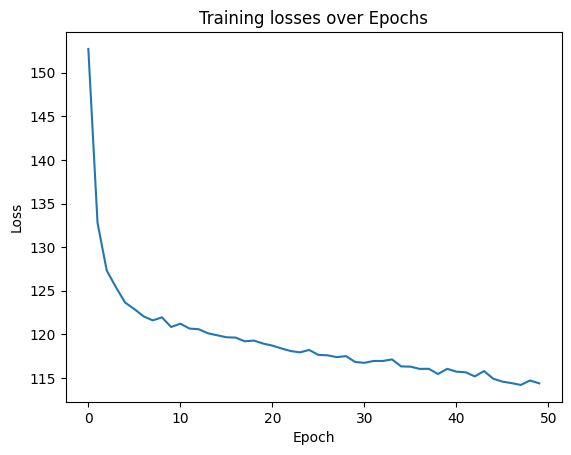

In [43]:
# Training the original model:
train_losses = []
print('Training the original model...')
for epoch in range(50):
    print('Epoch:', epoch)
    epoch_loss = 0
    shuffle(ori_train)
    i = 0
    # Process the training data in batches of 32:
    while i < len(ori_train):
        batch = ori_train[i:i+32]
        i += 32
        # Get the sentence vectors and labels from the batch:
        sentence, label = zip(*batch)
        
        # Step 1: Process the input data:
        sentence = torch.Tensor(sentence) # [batch_size, 250]
        label = torch.LongTensor(label) # [batch_size]
        
        # Step 2: Zero the gradients:
        model_original.zero_grad()
        
        # Step 3: Run the forward propagation:
        output = model_original(sentence)
        
        # Step 4: Compute loss and gradients:
        loss = loss_function(output, label)
        epoch_loss += loss.item()
        loss.backward()
        
        # Step 5: Update the weights:
        optimizer_original.step()
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)    
    # Step 6: Early stopping:
    with torch.no_grad():
        if model_original.early_stop:
            # forward propagation
            # We convert the test examples to tensors and do the forward propagation
            dev_sentence, dev_label = zip(*ori_dev)
            dev_sentence = torch.tensor(dev_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
            dev_label = torch.tensor(dev_label, dtype=torch.long)   # [DEV_SIZE]        
            output = model_original(dev_sentence)    
                
            # total loss on the dev set
            dev_loss = loss_function(output, dev_label)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
                
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(output, dim=1)
            accuracy = torch.sum(pred_labels == dev_label).item() / len(dev_label)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
                
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss > previous_dev_loss:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()
        

In [44]:
# Test on test set after training:
with torch.no_grad():
    # forward propagation on test set
    test_sentence, test_label = zip(*ori_test)
    test_sentence = torch.tensor(test_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
    test_label = torch.tensor(test_label, dtype=torch.long)   # [DEV_SIZE]
    log_probs = model_original(test_sentence)
    
    # total loss on the test set
    test_loss = loss_function(log_probs, test_label)

            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_label).item() / len(test_label)
    
    # Print the results
    print("Result of the original model:")
    print("Loss on test set after training: %f\n" %(test_loss))
    print("Accuracy on test set after training: %3.2f\n" % (accuracy * 100))

Result of the original model:
Loss on test set after training: 0.510278

Accuracy on test set after training: 79.08



Training the retrofitted model...
Epoch: 0
Loss on training set at epoch 0 : 157.580038
Epoch: 1
Loss on training set at epoch 1 : 139.826117
Epoch: 2
Loss on training set at epoch 2 : 134.225087
Epoch: 3
Loss on training set at epoch 3 : 131.771088
Epoch: 4
Loss on training set at epoch 4 : 130.477195
Epoch: 5
Loss on training set at epoch 5 : 129.561761
Epoch: 6
Loss on training set at epoch 6 : 129.019128
Epoch: 7
Loss on training set at epoch 7 : 128.379280
Epoch: 8
Loss on training set at epoch 8 : 127.839535
Epoch: 9
Loss on training set at epoch 9 : 127.380830
Epoch: 10
Loss on training set at epoch 10 : 126.959473
Epoch: 11
Loss on training set at epoch 11 : 126.838611
Epoch: 12
Loss on training set at epoch 12 : 126.634512
Epoch: 13
Loss on training set at epoch 13 : 126.417471
Epoch: 14
Loss on training set at epoch 14 : 126.120874
Epoch: 15
Loss on training set at epoch 15 : 125.849154
Epoch: 16
Loss on training set at epoch 16 : 125.823046
Epoch: 17
Loss on training set at 

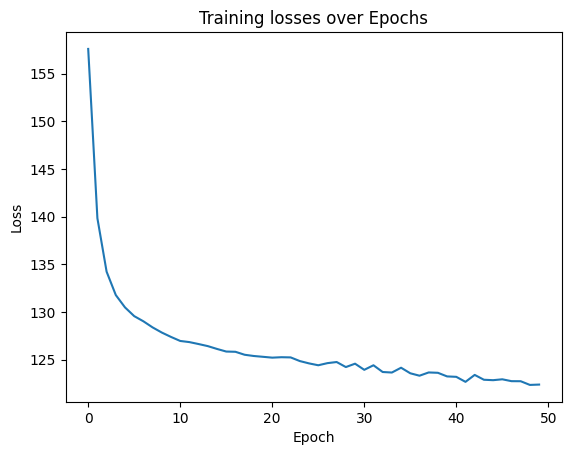

In [45]:
# Training the retrofitted model:
train_losses = []
print('Training the retrofitted model...')

for epoch in range(50):
    print('Epoch:', epoch)
    epoch_loss = 0
    shuffle(retro_train)
    i = 0
    # Process the training data in batches of 32:
    while i < len(retro_train):
        batch = retro_train[i:i+32]
        i += 32
        # Get the sentence vectors and labels from the batch:
        sentence, label = zip(*batch)
        
        # Step 1: Process the input data:
        sentence = torch.Tensor(sentence) # [batch_size, 250]
        label = torch.LongTensor(label) # [batch_size]
        
        # Step 2: Zero the gradients:
        model_retrofitted.zero_grad()
        
        # Step 3: Run the forward propagation:
        output = model_retrofitted(sentence)
        
        # Step 4: Compute loss and gradients:
        loss = loss_function(output, label)
        epoch_loss += loss.item()
        loss.backward()
        
        # Step 5: Update the weights:
        optimizer_retrofitted.step()
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)    
        # Step 6: Early stopping:
    with torch.no_grad():
        if model_retrofitted.early_stop:
            # forward propagation
            # We convert the test examples to tensors and do the forward propagation
            dev_sentence, dev_label = zip(*retro_dev)
            dev_sentence = torch.tensor(dev_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
            dev_label = torch.tensor(dev_label, dtype=torch.long)   # [DEV_SIZE]        
            output = model_retrofitted(dev_sentence)    
                
            # total loss on the dev set
            dev_loss = loss_function(output, dev_label)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
                
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(output, dim=1)
            accuracy = torch.sum(pred_labels == dev_label).item() / len(dev_label)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
                
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss > previous_dev_loss:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()
        

In [46]:
# Test on test set after training:
with torch.no_grad():
    # forward propagation on test set
    test_sentence, test_label = zip(*retro_test)
    test_sentence = torch.tensor(test_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
    test_label = torch.tensor(test_label, dtype=torch.long)   # [DEV_SIZE]
    log_probs = model_retrofitted(test_sentence)
    
    # total loss on the test set
    test_loss = loss_function(log_probs, test_label)
            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_label).item() / len(test_label)
    
    # Print the results:
    print("Result of the retrofitted model:")
    print("Loss on test set after training: %f\n" %(test_loss))
    print("Accuracy on test after training: %3.2f\n" % (accuracy * 100))

Result of the retrofitted model:
Loss on test set after training: 0.533914

Accuracy on test after training: 76.48

